In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
import os
root_path = 'gdrive/My Drive/HateXplain/'
os.chdir(root_path)

Mounted at /content/gdrive


In [2]:
!pip install sentencepiece==0.1.94
!pip install transformers==4.0.1
!pip install ekphrasis
# !pip install demoji
# !pip install tweet-preprocessor

     |████████████████████████████████| 1.1MB 6.1MB/s 
     |████████████████████████████████| 1.4MB 5.8MB/s 
     |████████████████████████████████| 890kB 27.7MB/s 
     |████████████████████████████████| 2.9MB 35.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ffcb3add83bce8840f247169daf012b79779a465aba3157008685ac6bb81e216
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 184kB 8.7MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82844 sha256=9f55174bb032bf6ecce2076244022c0d58d34ff70dbde2cdcfa1db3d9148d1d5
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.8-cp36-non

In [12]:
import numpy as np
import pandas as pd
import pickle
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pickle
import json
from sklearn.metrics import accuracy_score
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import re
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42
model_path = 'bert-base-uncased'
# model_path = 'monsoon-nlp/tamillion'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)
%load_ext autoreload
%autoreload 2

In [5]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    fix_html=True,  # fix HTML tokens
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    #corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


In [6]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [7]:
class Dataset():
    def __init__(self, data, batch_size = 32):
        self.data = data
        # self.val_data = val_data
        self.batch_size = batch_size

        self.label_dict = {0: 0,
                            1: 2,
                            2: 1}
                                    
        self.count_dic = {}
        self.inputs, self.labels = self.process_data(self.data)
        self.DataLoader = self.get_dataloader(self.inputs, self.labels)
        # self.train_dataloader = self.process_data(dataset_file, post_id_divisions_file, 'train')
        # self.val_dataloader = self.process_data(dataset_file, post_id_divisions_file, 'test')
        # self.test_dataloader = self.process_data(dataset_file, post_id_divisions_file, 'test')

    def ek_extra_preprocess(self, text):
        remove_words=['<allcaps>','</allcaps>','<hashtag>','</hashtag>','<elongated>','<emphasis>','<repeated>','\'','s']
        word_list=text_processor.pre_process_doc(text)
        word_list=list(filter(lambda a: a not in remove_words, word_list)) 
        sent=" ".join(word_list)
        sent = re.sub(r"[<\*>]", " ",sent)
        return sent

    def tokenize(self, sentences, padding = True, max_len = 128):
        tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        input_ids, attention_masks, token_type_ids = [], [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': input_ids, 'attention_masks': attention_masks}
    
    def process_data(self, data):
        sentences, labels = [], []
        print(len(data))
        for label, sentence in zip(list(data['class']), list(data['tweet'])):
            label = self.label_dict[label]
            sentence = self.ek_extra_preprocess(sentence)
            sentences.append(sentence)
            labels.append(label)
        inputs = self.tokenize(sentences)
        return inputs, torch.Tensor(labels)
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
        else:
            sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=self.batch_size)

In [8]:
# df = pd.read_csv('Data/labeled_data.csv', sep=',', engine='python')
# df = df.rename(columns={'Unnamed: 0': 'id'})
# df_train, df_val, df_test = split_stratified_into_train_val_test(df, stratify_colname='class',
#                                          frac_train=0.8, frac_val=0.1, frac_test=0.1,
#                                          random_state=RANDOM_SEED)
# df_train.to_csv('Data/train_data.csv',index = False)
# df_val.to_csv('Data/val_data.csv',index = False)
# df_test.to_csv('Data/test_data.csv',index = False)

In [9]:
df_train = pd.read_csv('Data/train_data.csv', sep=',', engine='python')
df_val = pd.read_csv('Data/val_data.csv', sep=',', engine='python')
df_test = pd.read_csv('Data/test_data.csv', sep=',', engine='python')
train_data, val_data, test_data = Dataset(df_train), Dataset(df_val), Dataset(df_test)

19826



2478
2479


In [ ]:
df = pd.concat([df_train[df_train['class']==0].sample(n=100, random_state = RANDOM_SEED),
            df_train[df_train['class']==1].sample(n=100, random_state = RANDOM_SEED),
            df_train[df_train['class']==2].sample(n=100, random_state = RANDOM_SEED)],
            ignore_index = True)
data = Dataset(df)

300


In [ ]:
data.DataLoader

In [10]:
class SC_weighted_BERT(nn.Module):
    def __init__(self, model_path):
        super(SC_weighted_BERT, self).__init__()
        self.num_labels = 3
        self.weights=[1.0795518,  0.82139814, 1.1678787]
        self.train_att= True
        self.lam = 100
        self.num_sv_heads = 6
        self.sv_layer = 11
        self.bert = AutoModel.from_pretrained(model_path)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 3)
        #self.softmax=nn.Softmax(config.num_labels)
        # self.init_weights()

    def forward(self,
        input_ids=None,
        attention_mask=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        #logits = self.softmax(logits)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        
        # if labels is not None:
        # loss_funct = nn.CrossEntropyLoss(weight=torch.tensor(self.weights).to(device))
        # loss_logits =  loss_funct(logits.view(-1, self.num_labels), labels.view(-1))
        # loss= loss_logits
            # if(self.train_att):
                
            #     loss_att=0
            #     for i in range(self.num_sv_heads):
            #         attention_weights=outputs[1][self.sv_layer][:,i,0,:]
            #         loss_att +=self.lam*masked_cross_entropy(attention_weights,attention_vals,attention_mask)
            #     loss = loss + loss_att
        outputs = outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [13]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat
 
def evaluate(test_dataloader, model):
    model.eval()
    y_preds, y_test = np.array([]), np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        ypred = ypred[0].cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))

    weighted_f1 = f1_score(y_test, y_preds, average='macro')
    report = classification_report(y_test, y_preds)
    print(report)
    return weighted_f1, y_preds, y_test
 
def train(training_dataloader, validation_dataloader, model, filepath = None, weights = None, learning_rate = 2e-5, epochs = 1, print_every = 10):
    total_steps = len(training_dataloader) * epochs
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    best_weighted_f1 = 0
    best_model = None
    # current_epoch, best_weighted_f1 = load_metrics(filepath, model, optimizer)
    if weights == None:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=weights)
    for epoch_i in tqdm(range(0, epochs)):
        model.train()
        for step, batch in enumerate(training_dataloader):
            b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
            
            outputs = model(b_input_ids, b_input_mask)
            loss = criterion(outputs[0], b_labels)
 
            if step%print_every == 0:
                print(loss.item())
 
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
 
        print('### Validation Set Stats')
        weighted_f1, ypred, ytest = evaluate(validation_dataloader, model)
        print("  Macro F1: {0:.3f}".format(weighted_f1))
        if weighted_f1 > best_weighted_f1:
            best_weighted_f1 = weighted_f1
            best_model = model
            # save_metrics(filepath, epoch_i, model, optimizer, weighted_f1)
        
    return model

In [ ]:
try:
    with open('data_dict_random_ratio.pkl', 'rb') as f:
        data_dict = pickle.load(f)
except:
    data_dict = {}
    with open('data_dict_random_ratio.pkl', 'wb') as f:
        pickle.dump(data_dict, f)

In [ ]:
random_seeds = [766, 1009, 994, 89, 571]
attentions = [0, 0.001, 0.01, 0.1, 1, 10, 100]
N = [0, 20, 50, 100, 200, 300, 400, 500]
for random_seed in random_seeds:
    for n in N:
        if n!=0:
            df = pd.concat([df_train[df_train['class']==0].sample(n=n, random_state = random_seed),
                        df_train[df_train['class']==1].sample(n=n, random_state = random_seed),
                        df_train[df_train['class']==2].sample(n=n, random_state = random_seed)],
                        ignore_index = True)
            data = Dataset(df)
        for attn in attentions:
            if attn not in data_dict: data_dict[attn] = {}
            if n not in data_dict[attn]: data_dict[attn][n] = {}
            if random_seed in data_dict[attn][n]: continue
            model = SC_weighted_BERT(model_path)
            # model.load_state_dict(torch.load('./Saved/bert-base-uncased_11_6_3_100/pytorch_model.bin', 'cpu'))
            model.to(device)
            if attn!=0:
                model.load_state_dict(torch.load('./Saved/bert-base-uncased_11_6_3_'+str(attn)+'/pytorch_model.bin', 'cpu'))
            else:
                model.load_state_dict(torch.load('./Saved/bert-base-uncased__3/pytorch_model.bin', 'cpu'))
            model.to(device)
            if n!=0:
                model = train(data.DataLoader, val_data.DataLoader, model, None, epochs = 4)
            f1, ypreds, ytest = evaluate(test_data.DataLoader, model)
            acc = accuracy_score(ytest, ypreds)
            with open('data_dict_random.pkl', 'rb') as f:
                data_dict = pickle.load(f)

            if attn not in data_dict: data_dict[attn] = {}
            if n not in data_dict[attn]: data_dict[attn][n] = {}
            if random_seed in data_dict[attn][n]: continue

            data_dict[attn][n][random_seed] = {'f1': f1, 'acc':acc}
            print(attn, n, data_dict[attn][n])
            with open('data_dict_random.pkl', 'wb') as f:
                pickle.dump(data_dict, f)
        print(data_dict)

In [ ]:
data_dict

{0: {0: {89: {'acc': 0.6058894715611134, 'f1': 0.48261655876313364},
   766: {'acc': 0.6058894715611134, 'f1': 0.48261655876313364},
   994: {'acc': 0.6058894715611134, 'f1': 0.48261655876313364},
   1009: {'acc': 0.6058894715611134, 'f1': 0.48261655876313364}},
  20: {89: {'acc': 0.7777329568374345, 'f1': 0.5666394432963956},
   766: {'acc': 0.7765227914481646, 'f1': 0.5662305683142136},
   994: {'acc': 0.7793465106897943, 'f1': 0.5672241509947215},
   1009: {'acc': 0.7773295683743445, 'f1': 0.5656617844323315}},
  50: {766: {'acc': 0.800726099233562, 'f1': 0.5624688061203651},
   994: {'acc': 0.8039532069382815, 'f1': 0.5619806699307892},
   1009: {'acc': 0.800726099233562, 'f1': 0.5652408091981878}},
  100: {766: {'acc': 0.8108108108108109, 'f1': 0.5781238462200954},
   994: {'acc': 0.8176684146833401, 'f1': 0.5866374762432877},
   1009: {'acc': 0.8176684146833401, 'f1': 0.5724136998496928}},
  200: {766: {'acc': 0.8398547801532876, 'f1': 0.6220750795278603},
   994: {'acc': 0.83743

In [15]:
model = SC_weighted_BERT(model_path)
model.load_state_dict(torch.load('./Saved/bert-base-uncased_11_6_3_100/pytorch_model.bin', 'cpu'))
model.to(device)

model = train(train_data.DataLoader, val_data.DataLoader, model, None, epochs = 4)
f1, ypreds, ytest = evaluate(test_data.DataLoader, model)

  0%|          | 0/4 [00:00<?, ?it/s]

1.7733023166656494
0.4201529026031494
0.36012375354766846
0.1571875661611557
0.24424801766872406
0.3774818778038025
0.26720544695854187
0.5432639718055725
0.5805017948150635
0.12914222478866577
0.5311329960823059
0.3602936267852783
0.45253971219062805
0.40496790409088135
0.25667837262153625
0.09504315257072449
0.23514121770858765
0.20568957924842834
0.11775447428226471
0.2159736156463623
0.1311604529619217
0.13611119985580444
0.37744447588920593
0.26994186639785767
0.5236008167266846
0.1428997814655304
0.2604735195636749
0.15183967351913452
0.22543743252754211
0.3013246953487396
0.0393860749900341
0.09374061226844788
0.2594847083091736
0.08566553890705109
0.3818163275718689
0.10589335858821869
0.06845802813768387
0.12216012924909592
0.14781619608402252
0.17110192775726318
0.22341382503509521
0.157237246632576
0.19549547135829926
0.29382652044296265
0.39892998337745667
0.046918608248233795
0.09198430180549622
0.37245237827301025
0.14821037650108337
0.2832726538181305
0.2268085926771164


 25%|██▌       | 1/4 [04:09<12:29, 249.67s/it]

              precision    recall  f1-score   support

         0.0       0.67      0.27      0.38       143
         1.0       0.89      0.93      0.91       416
         2.0       0.94      0.97      0.95      1919

    accuracy                           0.92      2478
   macro avg       0.83      0.72      0.75      2478
weighted avg       0.91      0.92      0.91      2478

  Macro F1: 0.748
0.09766589850187302
0.22315888106822968
0.3152173161506653
0.09681622684001923
0.06995144486427307
0.0995115414261818
0.10056595504283905
0.09903087466955185
0.17294438183307648
0.14597074687480927
0.09706617891788483
0.21921932697296143
0.30720752477645874
0.09795236587524414
0.31728988885879517
0.18594981729984283
0.12544283270835876
0.09032941609621048
0.21022789180278778
0.3049658536911011
0.13257817924022675
0.2393895834684372
0.14868463575839996
0.16637511551380157
0.334443598985672
0.29783135652542114
0.18304532766342163
0.202060267329216
0.24284465610980988
0.4074467122554779
0.46154320

 50%|█████     | 2/4 [08:19<08:19, 249.60s/it]

              precision    recall  f1-score   support

         0.0       0.56      0.45      0.50       143
         1.0       0.94      0.81      0.87       416
         2.0       0.93      0.97      0.95      1919

    accuracy                           0.91      2478
   macro avg       0.81      0.74      0.77      2478
weighted avg       0.91      0.91      0.91      2478

  Macro F1: 0.770
0.10811055451631546
0.04077881947159767
0.042099423706531525
0.17283891141414642
0.11799808591604233
0.04301251843571663
0.13471899926662445
0.09255623072385788
0.08724970370531082
0.08005236089229584
0.11762230098247528
0.09052176028490067
0.18199710547924042
0.22183842957019806
0.09736192226409912
0.08700177073478699
0.08326146751642227
0.1623888909816742
0.17460161447525024
0.06219986081123352
0.1215849295258522
0.1159069612622261
0.11775325983762741
0.20985282957553864
0.29564377665519714
0.06240145117044449
0.1457889825105667
0.22013618052005768
0.020210951566696167
0.10717812925577164
0.0

 75%|███████▌  | 3/4 [12:28<04:09, 249.52s/it]

              precision    recall  f1-score   support

         0.0       0.54      0.43      0.48       143
         1.0       0.91      0.88      0.89       416
         2.0       0.94      0.96      0.95      1919

    accuracy                           0.92      2478
   macro avg       0.80      0.76      0.77      2478
weighted avg       0.91      0.92      0.91      2478

  Macro F1: 0.774
0.08693297952413559
0.01660972833633423
0.03122277744114399
0.3880515396595001
0.05371056869626045
0.04617691785097122
0.3560054302215576
0.030777180567383766
0.16348540782928467
0.20904386043548584
0.29207465052604675
0.12792545557022095
0.22144468128681183
0.04255096986889839
0.07277391850948334
0.03207630291581154
0.09683540463447571
0.04874904081225395
0.02019757218658924
0.2490498274564743
0.010691369883716106
0.11527225375175476
0.1704416126012802
0.06410226970911026
0.038480814546346664
0.03810616955161095
0.22187036275863647
0.39354559779167175
0.13987743854522705
0.05294295772910118
0.

100%|██████████| 4/4 [16:37<00:00, 249.43s/it]

              precision    recall  f1-score   support

         0.0       0.54      0.46      0.50       143
         1.0       0.92      0.86      0.89       416
         2.0       0.94      0.96      0.95      1919

    accuracy                           0.91      2478
   macro avg       0.80      0.76      0.78      2478
weighted avg       0.91      0.91      0.91      2478

  Macro F1: 0.779


              precision    recall  f1-score   support

         0.0       0.51      0.37      0.43       143
         1.0       0.91      0.89      0.90       417
         2.0       0.94      0.96      0.95      1919

    accuracy                           0.92      2479
   macro avg       0.79      0.74      0.76      2479
weighted avg       0.91      0.92      0.91      2479



In [16]:
f1

0.7605053984726062

In [ ]:
random_seeds = [766, 1009, 994, 89, 571]
attentions = [0, 0.001, 0.01, 0.1, 1, 10, 100]
N = [0, 20, 50, 100, 200, 300, 400, 500]
for random_seed in random_seeds:
    for n in N:
        if n!=0:
            frac_train = n/len(df_train)
            frac_val = (1-frac_train)/2
            df, _, _ = split_stratified_into_train_val_test(df_train, stratify_colname='class',
                                         frac_train=frac_train, frac_val=frac_val, frac_test=1-frac_train-frac_val,
                                         random_state=RANDOM_SEED)
            data = Dataset(df)
        for attn in attentions:
            if attn not in data_dict: data_dict[attn] = {}
            if n not in data_dict[attn]: data_dict[attn][n] = {}
            if random_seed in data_dict[attn][n]: continue
            model = SC_weighted_BERT(model_path)
            # model.load_state_dict(torch.load('./Saved/bert-base-uncased_11_6_3_100/pytorch_model.bin', 'cpu'))
            model.to(device)
            if attn!=0:
                model.load_state_dict(torch.load('./Saved/bert-base-uncased_11_6_3_'+str(attn)+'/pytorch_model.bin', 'cpu'))
            else:
                model.load_state_dict(torch.load('./Saved/bert-base-uncased__3/pytorch_model.bin', 'cpu'))
            model.to(device)
            if n!=0:
                model = train(data.DataLoader, val_data.DataLoader, model, None, epochs = 4)
            f1, ypreds, ytest = evaluate(test_data.DataLoader, model)
            acc = accuracy_score(ytest, ypreds)
            with open('data_dict_random_ratio.pkl', 'rb') as f:
                data_dict = pickle.load(f)

            if attn not in data_dict: data_dict[attn] = {}
            if n not in data_dict[attn]: data_dict[attn][n] = {}
            if random_seed in data_dict[attn][n]: continue

            data_dict[attn][n][random_seed] = {'f1': f1, 'acc':acc}
            print(attn, n, data_dict[attn][n])
            with open('data_dict_random_ratio.pkl', 'wb') as f:
                pickle.dump(data_dict, f)
        print(data_dict)

{0: {0: {766: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 1009: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 994: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 89: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 571: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}}, 20: {766: {'f1': 0.5662305683142136, 'acc': 0.7765227914481646}, 1009: {'f1': 0.5656617844323315, 'acc': 0.7773295683743445}, 994: {'f1': 0.5672241509947215, 'acc': 0.7793465106897943}, 89: {'f1': 0.5666394432963956, 'acc': 0.7777329568374345}, 571: {'f1': 0.5653898470963834, 'acc': 0.7773295683743445}}, 50: {766: {'f1': 0.5624688061203651, 'acc': 0.800726099233562}, 1009: {'f1': 0.5652408091981878, 'acc': 0.800726099233562}, 994: {'f1': 0.5619806699307892, 'acc': 0.8039532069382815}, 89: {'f1': 0.5649592589098643, 'acc': 0.7987091569181122}, 571: {'f1': 0.5624090716917476, 'acc': 0.7991125453812021}}, 100: {766: {'f1': 0.5781238462200954, 'acc': 0.8108108108108109}, 1009: {'f

  0%|          | 0/4 [00:00<?, ?it/s]

1.0123851299285889
### Validation Set Stats


 25%|██▌       | 1/4 [00:22<01:06, 22.15s/it]

  Macro F1: 0.531
0.4655549228191376
### Validation Set Stats


 50%|█████     | 2/4 [00:44<00:44, 22.20s/it]

  Macro F1: 0.633
0.31080588698387146
### Validation Set Stats


 75%|███████▌  | 3/4 [01:07<00:22, 22.45s/it]

  Macro F1: 0.648
0.28897804021835327
### Validation Set Stats


100%|██████████| 4/4 [01:30<00:00, 22.72s/it]

  Macro F1: 0.661


0 300 {766: {'f1': 0.6415745362850297, 'acc': 0.8523598225090763}, 1009: {'f1': 0.6358960674973134, 'acc': 0.8475191609519968}, 994: {'f1': 0.6444264254540705, 'acc': 0.8527632109721662}, 89: {'f1': 0.6505698884019072, 'acc': 0.8551835417507059}, 571: {'f1': 0.6457042697712145, 'acc': 0.8531665994352562}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.6621273756027222
### Validation Set Stats


 25%|██▌       | 1/4 [00:24<01:12, 24.14s/it]

  Macro F1: 0.599
0.3255244791507721
### Validation Set Stats


 50%|█████     | 2/4 [00:49<00:48, 24.38s/it]

  Macro F1: 0.676
0.3855067193508148
### Validation Set Stats


 75%|███████▌  | 3/4 [01:14<00:24, 24.59s/it]

  Macro F1: 0.674
0.1455819457769394
### Validation Set Stats


100%|██████████| 4/4 [01:39<00:00, 24.83s/it]

  Macro F1: 0.674


0.001 300 {766: {'f1': 0.6521108508334491, 'acc': 0.8600242033077854}, 1009: {'f1': 0.6444776628600157, 'acc': 0.8620411456232352}, 994: {'f1': 0.6518334335575561, 'acc': 0.8668818071803146}, 89: {'f1': 0.6499170227422092, 'acc': 0.8620411456232352}, 571: {'f1': 0.6467068408441943, 'acc': 0.864058087938685}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.0253649950027466
### Validation Set Stats


 25%|██▌       | 1/4 [00:25<01:15, 25.15s/it]

  Macro F1: 0.617
0.42398402094841003
### Validation Set Stats


 50%|█████     | 2/4 [00:50<00:50, 25.23s/it]

  Macro F1: 0.670
0.3735911250114441
### Validation Set Stats


 75%|███████▌  | 3/4 [01:16<00:25, 25.40s/it]

  Macro F1: 0.688
0.21250729262828827
### Validation Set Stats


100%|██████████| 4/4 [01:42<00:00, 25.61s/it]

  Macro F1: 0.690


0.01 300 {766: {'f1': 0.6515730957529957, 'acc': 0.8684953610326744}, 1009: {'f1': 0.6413707890303221, 'acc': 0.8648648648648649}, 994: {'f1': 0.6467380467401442, 'acc': 0.863654699475595}, 89: {'f1': 0.6423092240054951, 'acc': 0.8620411456232352}, 571: {'f1': 0.650654872791308, 'acc': 0.8664784187172246}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.8897936940193176
### Validation Set Stats


 25%|██▌       | 1/4 [00:25<01:15, 25.16s/it]

  Macro F1: 0.581
0.4233004152774811
### Validation Set Stats


 50%|█████     | 2/4 [00:51<00:50, 25.37s/it]

  Macro F1: 0.669
0.2679859399795532
### Validation Set Stats


 75%|███████▌  | 3/4 [01:17<00:25, 25.61s/it]

  Macro F1: 0.681
0.25239744782447815
### Validation Set Stats


100%|██████████| 4/4 [01:43<00:00, 25.83s/it]

  Macro F1: 0.686


0.1 300 {766: {'f1': 0.6516632519739752, 'acc': 0.8709156918112142}, 1009: {'f1': 0.6558977091114858, 'acc': 0.8713190802743042}, 994: {'f1': 0.6565735846459558, 'acc': 0.872529245663574}, 89: {'f1': 0.6533150118046752, 'acc': 0.8713190802743042}, 571: {'f1': 0.6652332287314211, 'acc': 0.8709156918112142}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.1237077713012695
### Validation Set Stats


 25%|██▌       | 1/4 [00:25<01:17, 25.75s/it]

  Macro F1: 0.608
0.23073551058769226
### Validation Set Stats


 50%|█████     | 2/4 [00:52<00:52, 26.00s/it]

  Macro F1: 0.667
0.2674601972103119
### Validation Set Stats


 75%|███████▌  | 3/4 [01:18<00:25, 26.00s/it]

  Macro F1: 0.682
0.30596283078193665
### Validation Set Stats


100%|██████████| 4/4 [01:44<00:00, 26.09s/it]

  Macro F1: 0.684


1 300 {766: {'f1': 0.6643776670962075, 'acc': 0.8616377571601452}, 1009: {'f1': 0.6489885477062926, 'acc': 0.8592174263816055}, 994: {'f1': 0.6638537820079402, 'acc': 0.8648648648648649}, 89: {'f1': 0.6539550115622483, 'acc': 0.8580072609923356}, 571: {'f1': 0.6701898824213259, 'acc': 0.8660750302541347}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.596248984336853
### Validation Set Stats


 25%|██▌       | 1/4 [00:25<01:17, 25.99s/it]

  Macro F1: 0.599
0.3166855573654175
### Validation Set Stats


 50%|█████     | 2/4 [00:52<00:52, 26.15s/it]

  Macro F1: 0.669
0.17562848329544067
### Validation Set Stats


 75%|███████▌  | 3/4 [01:18<00:26, 26.09s/it]

  Macro F1: 0.663
0.21205277740955353
### Validation Set Stats


100%|██████████| 4/4 [01:44<00:00, 26.14s/it]

  Macro F1: 0.663


10 300 {766: {'f1': 0.6456743350170062, 'acc': 0.8511496571198064}, 1009: {'f1': 0.6500676964061189, 'acc': 0.8535699878983461}, 994: {'f1': 0.6493117130849594, 'acc': 0.8519564340459863}, 89: {'f1': 0.6559923100619295, 'acc': 0.8539733763614361}, 571: {'f1': 0.627914720572483, 'acc': 0.8588140379185155}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.3203036785125732
### Validation Set Stats


 25%|██▌       | 1/4 [00:26<01:18, 26.23s/it]

  Macro F1: 0.608
0.22834059596061707
### Validation Set Stats


 50%|█████     | 2/4 [00:52<00:52, 26.30s/it]

  Macro F1: 0.700
0.2699289619922638
### Validation Set Stats


 75%|███████▌  | 3/4 [01:18<00:26, 26.18s/it]

  Macro F1: 0.684
0.25799360871315
### Validation Set Stats


100%|██████████| 4/4 [01:44<00:00, 26.16s/it]

  Macro F1: 0.686


100 300 {766: {'f1': 0.662459360377651, 'acc': 0.8701089148850343}, 1009: {'f1': 0.6684153414328904, 'acc': 0.8620411456232352}, 994: {'f1': 0.6647868199675907, 'acc': 0.872529245663574}, 89: {'f1': 0.672481597407168, 'acc': 0.8676885841064945}, 571: {'f1': 0.6719333968842746, 'acc': 0.8713190802743042}}
{0: {0: {766: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 1009: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 994: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 89: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 571: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}}, 20: {766: {'f1': 0.5662305683142136, 'acc': 0.7765227914481646}, 1009: {'f1': 0.5656617844323315, 'acc': 0.7773295683743445}, 994: {'f1': 0.5672241509947215, 'acc': 0.7793465106897943}, 89: {'f1': 0.5666394432963956, 'acc': 0.7777329568374345}, 571: {'f1': 0.5653898470963834, 'acc': 0.7773295683743445}}, 50: {766: {'f1': 0.5624688061203651, 'acc': 0.800726099233562}, 1009: {'f

  0%|          | 0/4 [00:00<?, ?it/s]

0.7183384895324707
0.5173076391220093
### Validation Set Stats


 25%|██▌       | 1/4 [00:28<01:24, 28.24s/it]

  Macro F1: 0.566
0.2506219744682312
0.4693107008934021
### Validation Set Stats


 50%|█████     | 2/4 [00:56<00:56, 28.31s/it]

  Macro F1: 0.642
0.3581812381744385
0.3669454753398895
### Validation Set Stats


 75%|███████▌  | 3/4 [01:24<00:28, 28.28s/it]

  Macro F1: 0.676
0.20998260378837585
0.2715994417667389
### Validation Set Stats


100%|██████████| 4/4 [01:53<00:00, 28.25s/it]

  Macro F1: 0.672


0 400 {766: {'f1': 0.6554887461653999, 'acc': 0.8555869302137958}, 1009: {'f1': 0.6537999140679772, 'acc': 0.8535699878983461}, 994: {'f1': 0.6556428075879098, 'acc': 0.8543767648245261}, 89: {'f1': 0.6553980107509576, 'acc': 0.8567970956030657}, 571: {'f1': 0.6602809199956293, 'acc': 0.8559903186768858}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.8273802399635315
0.450593501329422
### Validation Set Stats


 25%|██▌       | 1/4 [00:28<01:26, 28.76s/it]

  Macro F1: 0.645
0.5066250562667847
0.2027425467967987
### Validation Set Stats


 50%|█████     | 2/4 [00:57<00:57, 28.68s/it]

  Macro F1: 0.687
0.4395608603954315
0.213660329580307
### Validation Set Stats


 75%|███████▌  | 3/4 [01:25<00:28, 28.46s/it]

  Macro F1: 0.698
0.15434530377388
0.4161332845687866
### Validation Set Stats


100%|██████████| 4/4 [01:53<00:00, 28.39s/it]

  Macro F1: 0.690


0.001 400 {766: {'f1': 0.6627050252304835, 'acc': 0.8688987494957644}, 1009: {'f1': 0.6558539066897447, 'acc': 0.8648648648648649}, 994: {'f1': 0.6606529943236804, 'acc': 0.8705123033481242}, 89: {'f1': 0.6658568607124847, 'acc': 0.8705123033481242}, 571: {'f1': 0.6596733190475991, 'acc': 0.8664784187172246}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.0702598094940186
0.3596729338169098
### Validation Set Stats


 25%|██▌       | 1/4 [00:28<01:25, 28.53s/it]

  Macro F1: 0.627
0.2130926251411438
0.40583357214927673
### Validation Set Stats


 50%|█████     | 2/4 [00:57<00:57, 28.57s/it]

  Macro F1: 0.693
0.3492310047149658
0.15893138945102692
### Validation Set Stats


 75%|███████▌  | 3/4 [01:25<00:28, 28.41s/it]

  Macro F1: 0.701
0.3360908627510071
0.141278937458992
### Validation Set Stats


100%|██████████| 4/4 [01:53<00:00, 28.35s/it]

  Macro F1: 0.689


0.01 400 {766: {'f1': 0.6651138636921404, 'acc': 0.8713190802743042}, 1009: {'f1': 0.6556798699650789, 'acc': 0.872529245663574}, 994: {'f1': 0.6616163681921928, 'acc': 0.872932634126664}, 89: {'f1': 0.6615135776016071, 'acc': 0.8749495764421138}, 571: {'f1': 0.6556152606920299, 'acc': 0.873336022589754}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.8710205554962158
0.3899574875831604
### Validation Set Stats


 25%|██▌       | 1/4 [00:28<01:25, 28.59s/it]

  Macro F1: 0.646
0.29261311888694763
0.39763200283050537
### Validation Set Stats


 50%|█████     | 2/4 [00:57<00:57, 28.61s/it]

  Macro F1: 0.686
0.42256322503089905
0.13198286294937134
### Validation Set Stats


 75%|███████▌  | 3/4 [01:25<00:28, 28.37s/it]

  Macro F1: 0.684
0.24222332239151
0.15269289910793304
### Validation Set Stats


100%|██████████| 4/4 [01:53<00:00, 28.31s/it]

  Macro F1: 0.699


0.1 400 {766: {'f1': 0.6699407443692879, 'acc': 0.8854376764824526}, 1009: {'f1': 0.6786529227787322, 'acc': 0.881807180314643}, 994: {'f1': 0.670462642203539, 'acc': 0.881807180314643}, 89: {'f1': 0.6789484650502949, 'acc': 0.8870512303348125}, 571: {'f1': 0.6754763347738231, 'acc': 0.8842275110931828}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.808381199836731
0.38507020473480225
### Validation Set Stats


 25%|██▌       | 1/4 [00:28<01:26, 28.68s/it]

  Macro F1: 0.631
0.3373807668685913
0.390335351228714
### Validation Set Stats


 50%|█████     | 2/4 [00:57<00:57, 28.71s/it]

  Macro F1: 0.680
0.24014347791671753
0.37859776616096497
### Validation Set Stats


 75%|███████▌  | 3/4 [01:25<00:28, 28.41s/it]

  Macro F1: 0.698
0.3459871709346771
0.23112839460372925
### Validation Set Stats


100%|██████████| 4/4 [01:53<00:00, 28.35s/it]

  Macro F1: 0.698


1 400 {766: {'f1': 0.6678148283165278, 'acc': 0.8668818071803146}, 1009: {'f1': 0.665694927307256, 'acc': 0.8604275917708754}, 994: {'f1': 0.6754530143719696, 'acc': 0.8648648648648649}, 89: {'f1': 0.6750976678427906, 'acc': 0.8680919725695845}, 571: {'f1': 0.6723945306037352, 'acc': 0.8684953610326744}}


  0%|          | 0/4 [00:00<?, ?it/s]

2.4559390544891357
0.4000627100467682
### Validation Set Stats


 25%|██▌       | 1/4 [00:28<01:25, 28.55s/it]

  Macro F1: 0.630
0.3493712842464447
0.2277875691652298
### Validation Set Stats


 50%|█████     | 2/4 [00:57<00:57, 28.59s/it]

  Macro F1: 0.707
0.1440330594778061
0.21163660287857056
### Validation Set Stats


 75%|███████▌  | 3/4 [01:25<00:28, 28.38s/it]

  Macro F1: 0.678
0.38604775071144104
0.16075937449932098
### Validation Set Stats


100%|██████████| 4/4 [01:53<00:00, 28.34s/it]

  Macro F1: 0.686


10 400 {766: {'f1': 0.6723462464752917, 'acc': 0.8660750302541347}, 1009: {'f1': 0.6606530432282531, 'acc': 0.864058087938685}, 994: {'f1': 0.653433851259504, 'acc': 0.8624445340863252}, 89: {'f1': 0.6639156218084135, 'acc': 0.8652682533279549}, 571: {'f1': 0.672538687226576, 'acc': 0.8660750302541347}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.1648284196853638
0.6438205242156982
### Validation Set Stats


 25%|██▌       | 1/4 [00:28<01:25, 28.36s/it]

  Macro F1: 0.627
0.36613792181015015
0.24240756034851074
### Validation Set Stats


 50%|█████     | 2/4 [00:56<00:56, 28.41s/it]

  Macro F1: 0.684
0.2927703261375427
0.30066031217575073
### Validation Set Stats


 75%|███████▌  | 3/4 [01:24<00:28, 28.29s/it]

  Macro F1: 0.701
0.15702280402183533
0.12593573331832886
### Validation Set Stats


100%|██████████| 4/4 [01:52<00:00, 28.25s/it]

  Macro F1: 0.702


100 400 {766: {'f1': 0.663829389501251, 'acc': 0.873336022589754}, 1009: {'f1': 0.6813986106071109, 'acc': 0.8705123033481242}, 994: {'f1': 0.6851823922862885, 'acc': 0.8757563533682937}, 89: {'f1': 0.6837678253045304, 'acc': 0.8717224687373941}, 571: {'f1': 0.6790898951116141, 'acc': 0.873336022589754}}
{0: {0: {766: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 1009: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 994: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 89: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 571: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}}, 20: {766: {'f1': 0.5662305683142136, 'acc': 0.7765227914481646}, 1009: {'f1': 0.5656617844323315, 'acc': 0.7773295683743445}, 994: {'f1': 0.5672241509947215, 'acc': 0.7793465106897943}, 89: {'f1': 0.5666394432963956, 'acc': 0.7777329568374345}, 571: {'f1': 0.5653898470963834, 'acc': 0.7773295683743445}}, 50: {766: {'f1': 0.5624688061203651, 'acc': 0.800726099233562}, 1009: {'f

  0%|          | 0/4 [00:00<?, ?it/s]

0.9994509816169739
0.7457674145698547
### Validation Set Stats


 25%|██▌       | 1/4 [00:30<01:32, 30.69s/it]

  Macro F1: 0.548
0.5653464198112488
0.44850781559944153
### Validation Set Stats


 50%|█████     | 2/4 [01:01<01:01, 30.65s/it]

  Macro F1: 0.647
0.33007487654685974
0.307792991399765
### Validation Set Stats


 75%|███████▌  | 3/4 [01:31<00:30, 30.50s/it]

  Macro F1: 0.672
0.2796478569507599
0.08949580788612366
### Validation Set Stats


100%|██████████| 4/4 [02:01<00:00, 30.46s/it]

  Macro F1: 0.679


0 500 {766: {'f1': 0.6655284649939587, 'acc': 0.8616377571601452}, 1009: {'f1': 0.6656991467111072, 'acc': 0.8563937071399758}, 994: {'f1': 0.6612645327181065, 'acc': 0.8580072609923356}, 89: {'f1': 0.659325800253208, 'acc': 0.8592174263816055}, 571: {'f1': 0.6583289601644591, 'acc': 0.8596208148446954}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.7593703866004944
0.623442530632019
### Validation Set Stats


 25%|██▌       | 1/4 [00:30<01:32, 30.75s/it]

  Macro F1: 0.637
0.277797669172287
0.4379114806652069
### Validation Set Stats


 50%|█████     | 2/4 [01:01<01:01, 30.71s/it]

  Macro F1: 0.692
0.14522181451320648
0.3189540207386017
### Validation Set Stats


 75%|███████▌  | 3/4 [01:31<00:30, 30.51s/it]

  Macro F1: 0.692
0.2781529426574707
0.10032208263874054
### Validation Set Stats


100%|██████████| 4/4 [02:01<00:00, 30.48s/it]

  Macro F1: 0.695


0.001 500 {766: {'f1': 0.6690694421737621, 'acc': 0.8737394110528439}, 1009: {'f1': 0.6756429708774686, 'acc': 0.8797902379991932}, 994: {'f1': 0.6642424322581931, 'acc': 0.872529245663574}, 89: {'f1': 0.6704867256426131, 'acc': 0.8773699072206534}, 571: {'f1': 0.669225305313157, 'acc': 0.8721258572004841}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.9211298823356628
0.4297647476196289
### Validation Set Stats


 25%|██▌       | 1/4 [00:30<01:32, 30.67s/it]

  Macro F1: 0.632
0.5901777148246765
0.2847009003162384
### Validation Set Stats


 50%|█████     | 2/4 [01:01<01:01, 30.68s/it]

  Macro F1: 0.672
0.18415558338165283
0.32273921370506287
### Validation Set Stats


 75%|███████▌  | 3/4 [01:31<00:30, 30.51s/it]

  Macro F1: 0.685
0.10888039320707321
0.30235740542411804
### Validation Set Stats


100%|██████████| 4/4 [02:01<00:00, 30.49s/it]

  Macro F1: 0.686


0.01 500 {766: {'f1': 0.6634766194892777, 'acc': 0.8801936264622832}, 1009: {'f1': 0.6704115059743789, 'acc': 0.8793868495361032}, 994: {'f1': 0.6813590535748396, 'acc': 0.8721258572004841}, 89: {'f1': 0.6714012696488284, 'acc': 0.8801936264622832}, 571: {'f1': 0.6638689006966175, 'acc': 0.881403791851553}}


  0%|          | 0/4 [00:00<?, ?it/s]

0.9719852209091187
0.5274296402931213
### Validation Set Stats


 25%|██▌       | 1/4 [00:31<01:33, 31.03s/it]

  Macro F1: 0.667
0.4185664653778076
0.4088185131549835
### Validation Set Stats


 50%|█████     | 2/4 [01:01<01:01, 30.97s/it]

  Macro F1: 0.683
0.3269411325454712
0.2143605798482895
### Validation Set Stats


 75%|███████▌  | 3/4 [01:31<00:30, 30.64s/it]

  Macro F1: 0.701
0.38488879799842834
0.19369767606258392
### Validation Set Stats


100%|██████████| 4/4 [02:02<00:00, 30.57s/it]

  Macro F1: 0.697


0.1 500 {766: {'f1': 0.6936637745125491, 'acc': 0.8878580072609923}, 1009: {'f1': 0.6672932730833128, 'acc': 0.8846308995562727}, 994: {'f1': 0.6771827732495064, 'acc': 0.8866478418717225}, 89: {'f1': 0.6831615033011681, 'acc': 0.8870512303348125}, 571: {'f1': 0.6748648159065871, 'acc': 0.8858410649455426}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.076253890991211
0.418763667345047
### Validation Set Stats


 25%|██▌       | 1/4 [00:30<01:32, 30.81s/it]

  Macro F1: 0.671
0.34721213579177856
0.3208882212638855
### Validation Set Stats


 50%|█████     | 2/4 [01:01<01:01, 30.85s/it]

  Macro F1: 0.685
0.23896734416484833
0.15274693071842194
### Validation Set Stats


 75%|███████▌  | 3/4 [01:31<00:30, 30.51s/it]

  Macro F1: 0.707
0.2092389613389969
0.24567171931266785
### Validation Set Stats


100%|██████████| 4/4 [02:02<00:00, 30.50s/it]

  Macro F1: 0.695


1 500 {766: {'f1': 0.67329366095524, 'acc': 0.8676885841064945}, 1009: {'f1': 0.6794502656764999, 'acc': 0.8745461879790238}, 994: {'f1': 0.6840967369720365, 'acc': 0.8793868495361032}, 89: {'f1': 0.6665554121175057, 'acc': 0.8652682533279549}, 571: {'f1': 0.6701041694059491, 'acc': 0.8664784187172246}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.3278354406356812
0.579804003238678
### Validation Set Stats


 25%|██▌       | 1/4 [00:30<01:32, 30.83s/it]

  Macro F1: 0.609
0.1473570019006729
0.5264296531677246
### Validation Set Stats


 50%|█████     | 2/4 [01:01<01:01, 30.86s/it]

  Macro F1: 0.693
0.26412877440452576
0.17018015682697296
### Validation Set Stats


 75%|███████▌  | 3/4 [01:31<00:30, 30.58s/it]

  Macro F1: 0.701
0.07995770126581192
0.2272123396396637
### Validation Set Stats


100%|██████████| 4/4 [02:02<00:00, 30.56s/it]

  Macro F1: 0.709


10 500 {766: {'f1': 0.6797704203088437, 'acc': 0.873336022589754}, 1009: {'f1': 0.6893654983563443, 'acc': 0.8741427995159339}, 994: {'f1': 0.682470551787862, 'acc': 0.8721258572004841}, 89: {'f1': 0.6817288485601081, 'acc': 0.8676885841064945}, 571: {'f1': 0.670055422658573, 'acc': 0.8672851956434046}}


  0%|          | 0/4 [00:00<?, ?it/s]

1.1703468561172485
0.5677992105484009
### Validation Set Stats


 25%|██▌       | 1/4 [00:31<01:33, 31.02s/it]

  Macro F1: 0.688
0.21449904143810272
0.1432354599237442
### Validation Set Stats


 50%|█████     | 2/4 [01:01<01:01, 30.94s/it]

  Macro F1: 0.686
0.19529014825820923
0.2467322200536728
### Validation Set Stats


 75%|███████▌  | 3/4 [01:31<00:30, 30.64s/it]

  Macro F1: 0.700
0.25463879108428955
0.2921288013458252
### Validation Set Stats


100%|██████████| 4/4 [02:02<00:00, 30.55s/it]

  Macro F1: 0.704


100 500 {766: {'f1': 0.6929738076879066, 'acc': 0.8789834610730133}, 1009: {'f1': 0.6936385800831774, 'acc': 0.8830173457039129}, 994: {'f1': 0.6941320370294896, 'acc': 0.8757563533682937}, 89: {'f1': 0.673943560580891, 'acc': 0.8769665187575635}, 571: {'f1': 0.6918022227181382, 'acc': 0.882210568777733}}
{0: {0: {766: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 1009: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 994: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 89: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}, 571: {'f1': 0.48261655876313364, 'acc': 0.6058894715611134}}, 20: {766: {'f1': 0.5662305683142136, 'acc': 0.7765227914481646}, 1009: {'f1': 0.5656617844323315, 'acc': 0.7773295683743445}, 994: {'f1': 0.5672241509947215, 'acc': 0.7793465106897943}, 89: {'f1': 0.5666394432963956, 'acc': 0.7777329568374345}, 571: {'f1': 0.5653898470963834, 'acc': 0.7773295683743445}}, 50: {766: {'f1': 0.5624688061203651, 'acc': 0.800726099233562}, 1009: {'

In [ ]:
attentions = [0, 0.001, 0.01, 0.1, 1, 10, 100]
N = [0, 20, 50, 100, 200, 300, 400, 500]
for n in N:
    if n!=0:
        df = pd.concat([df_train[df_train['class']==0].sample(n=n, random_state = RANDOM_SEED),
                    df_train[df_train['class']==1].sample(n=n, random_state = RANDOM_SEED),
                    df_train[df_train['class']==2].sample(n=n, random_state = RANDOM_SEED)],
                    ignore_index = True)
        data = Dataset(df)
    for attn in attentions:
        if attn not in data_dict: data_dict[attn] = {}
        if n in data_dict[attn]: continue
        model = SC_weighted_BERT(model_path)
        # model.load_state_dict(torch.load('./Saved/bert-base-uncased_11_6_3_100/pytorch_model.bin', 'cpu'))
        model.to(device)
        if attn!=0:
            model.load_state_dict(torch.load('./Saved/bert-base-uncased_11_6_3_'+str(attn)+'/pytorch_model.bin', 'cpu'))
        else:
            model.load_state_dict(torch.load('./Saved/bert-base-uncased__3/pytorch_model.bin', 'cpu'))
        model.to(device)
        if n!=0:
            model = train(data.DataLoader, val_data.DataLoader, model, None, epochs = 4)
        f1, ypreds, ytest = evaluate(test_data.DataLoader, model)
        acc = accuracy_score(ytest, ypreds)
        with open('data_dict2.pkl', 'rb') as f:
            data_dict = pickle.load(f)

        if attn not in data_dict: data_dict[attn] = {}
        data_dict[attn][n] = {'f1': f1, 'acc':acc}
        print(attn, n, data_dict[attn][n])
        with open('data_dict2.pkl', 'wb') as f:
            pickle.dump(data_dict, f)
    print(data_dict)

In [ ]:
try:
    with open('data_dict1.pkl', 'rb') as f:
        data_dict = pickle.load(f)
except:
    data_dict = {}
    with open('data_dict1.pkl', 'wb') as f:
        pickle.dump(data_dict, f)

In [ ]:
model = SC_weighted_BERT(model_path)
model.load_state_dict(torch.load('./Saved/bert-base-uncased__3/pytorch_model.bin', 'cpu'))
model.to(device)
# model = train(data.DataLoader, val_data.DataLoader, model, None, epochs = 10)
f1, ypreds, ytest = evaluate(test_data.DataLoader, model)

In [ ]:

# f1, ypreds, ytest = evaluate(test_data.DataLoader, model)
print(accuracy_score(ytest, ypreds))
print(f1_score(ytest, ypreds, average='macro'))

0.6058894715611134
0.48261655876313364


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(ytest, ypreds))
print(f1_score(ytest, ypreds, average='macro'))

0.627672448567971
0.4957829435842558


In [ ]:
for x in ytest: print(x)

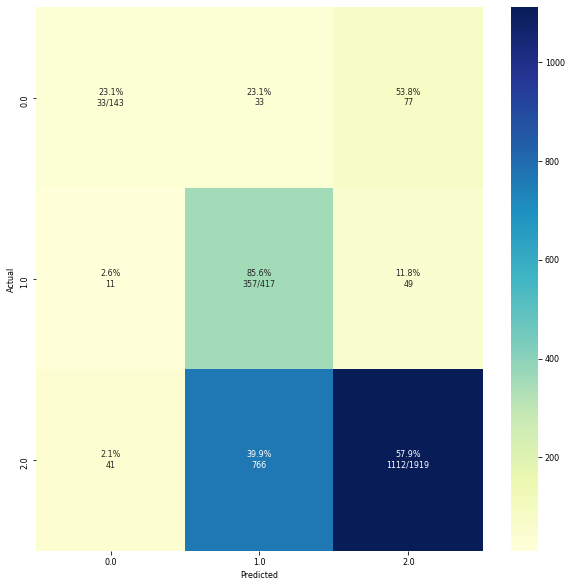

In [ ]:
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(ytest, ypreds)